# Use Case: Context-Aware Anomaly Detection im zivilen Luftraum

### 1. Die physikalische Ausgangslage
In der Luftfahrt unterliegen alle Bewegungen strengen physikalischen Gesetzen. Obwohl jedes Luftfahrzeug ein individuelles Profil hat, ergibt sich in der Masse ein stabiles Muster.

Es gelten fundamentale Regeln der Aerodynamik:
* **Höhe & Geschwindigkeit:** In dünnerer Luft (hohe Flughöhe) müssen Flugzeuge schneller fliegen, um genügend Auftrieb zu erzeugen.

* **Start & Landung:** Nahe am Boden sind Flugzeuge zwangsläufig langsamer.

**Realistische Benchmarks für "Normalität":**
* **Reiseflughöhe:** Zivile Jets operieren meist zwischen **9.000m und 12.000m**.
* **Reisegeschwindigkeit:** Üblich sind **800 bis 950 km/h**.
* **Stall Speed:** Die meisten Verkehrsflugzeuge benötigen mind. **200-300 km/h**, um stabil zu fliegen.

---

### 2. Das Ziel: Anomalie-Erkennung
Wir nutzen den **Isolation Forest**-Algorithmus (Unsupervised Learning), um Datenpunkte zu finden, die massiv von dieser "Norm" abweichen. Dabei suchen wir zwei Arten von Ausreißern:

1.  **Technische Anomalien:** Sensorfehler, bei denen unrealistische Werte übertragen werden (z. B. 10 km/h in 10.000m Höhe).
2.  **Operative Anomalien:** Luftfahrzeuge, die sich am physikalischen Limit bewegen (z. B. Kampfjets im Tiefflug oder extrem langsame Objekte).

---

### 3. Data Enrichment & Context-Awareness
Eine rein statistische Analyse hat eine Schwäche: Sie kennt den Unterschied zwischen einem **Airbus A320** und einem **Hubschrauber** nicht. Ein Hubschrauber, der mit 0 km/h schwebt, würde von einem "dummen" Algorithmus als Absturz (Anomalie) markiert werden.

Um dies zu beheben, integrieren wir eine **zweite Datenquelle**.

**Die Datenbasis (Data Engineering):**
Wir nutzen die **OpenSky Aircraft Database**, die wir zuvor über unsere Pipeline (`aircraft_type_ingest_s3.py`) automatisiert ingestiert und als performante **Parquet-Datei** (`aircraft_database.parquet`) bereitgestellt haben.

**Der Kontext-Join:**
Über die eindeutige Transponder-ID (**`icao24`**) verknüpfen wir die Positionsdaten mit den Stammdaten:
* `manufacturerName` (z.B. Airbus, Robinson)
* `model` (z.B. A320, R44)
* `categoryDescription` (z.B. Rotorcraft, Glider)

**Die Forschungsfrage:**
*Ist der gefundene Ausreißer ein physikalischer Fehler (z.B. ein Jet, der zu langsam ist) oder einfach ein Hubschrauber, der sich für seinen Typ völlig normal verhält?*

### Zelle 1: Daten laden & Visualisieren

Diese Zelle bereitet die Analyse-Basis vor und führt einen ersten Plausibilitäts-Check durch:

1.  **Automatischer Import:** Das Skript identifiziert und lädt automatisch den **zeitlich aktuellsten** Datensatz aus der Spark-Verarbeitung (`run_*`), um manuelle Pfad-Anpassungen zu vermeiden.
2.  **Filterung & Bereinigung:** Es werden nur fliegende Objekte (`onground=False`) betrachtet. Datentypen werden korrigiert und die Geschwindigkeit in `km/h` umgerechnet.
3.  **Physik-Visualisierung:** Erstellt ein Streudiagramm (Höhe vs. Geschwindigkeit) mit atmosphärischen Referenzschichten (Troposphäre/Stratosphäre) und Grenzlinien (Mt. Everest, Armstrong-Limit). Dies dient dazu, **grobe Datenfehler** sofort visuell von **echten Flugbewegungen** zu unterscheiden.

--- 1. LADEN & VISUALISIERUNG ---
Lade Datensatz: run_1769345704


Daten geladen: 1,080,730 Punkte.
Erstelle Diagramm mit atmosphärischen Schichten...


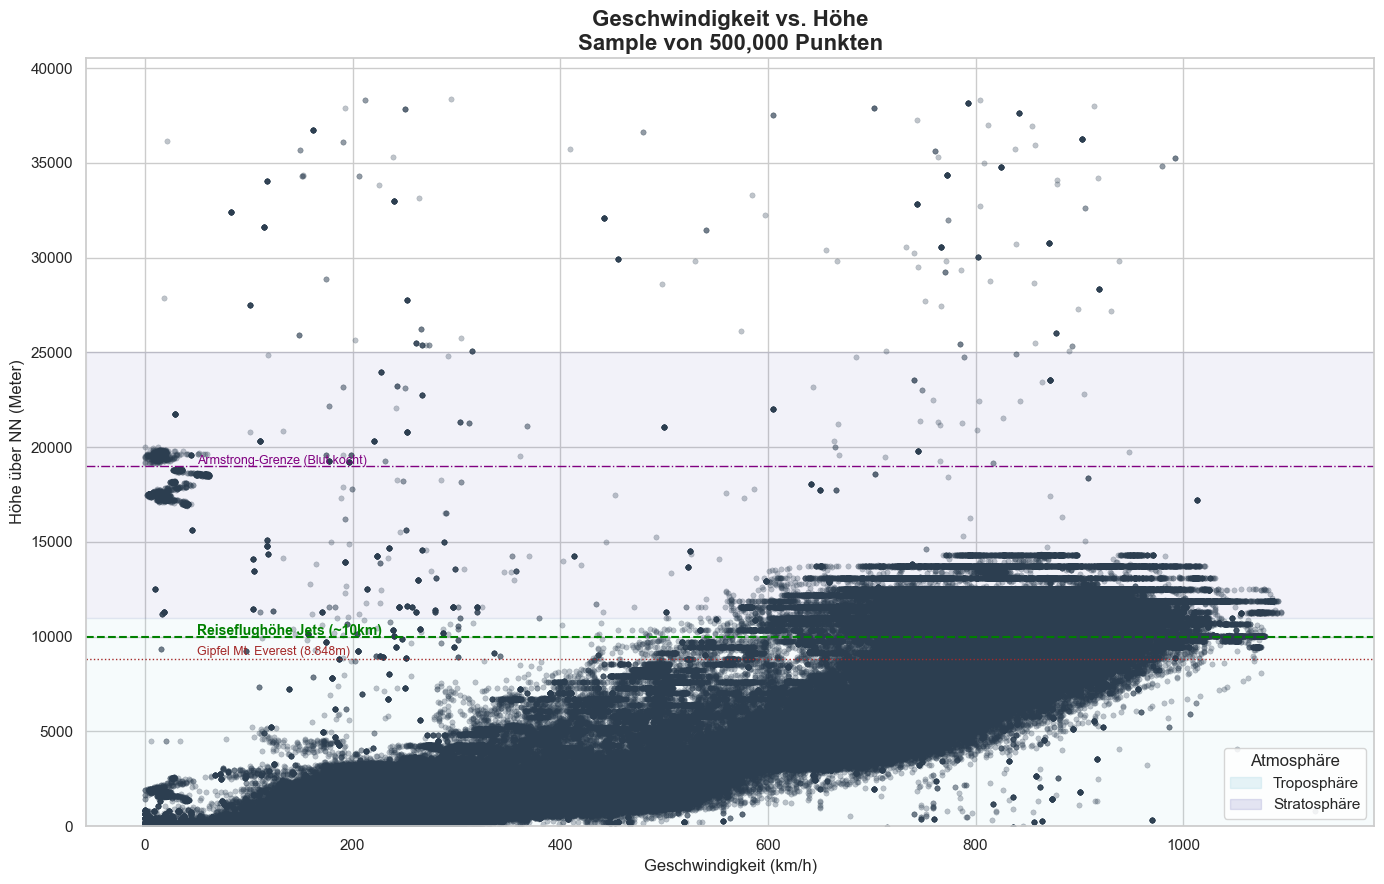

In [6]:
import pandas as pd
import glob
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

sns.set_theme(style="whitegrid")

print("--- 1. LADEN & VISUALISIERUNG ---")

# 1. DATEN LADEN
base_path = "../data/processed/run_*"
if not glob.glob(base_path): base_path = "../../data/processed/run_*"
latest_run = max(glob.glob(base_path), key=os.path.getctime)
print(f"Lade Datensatz: {os.path.basename(latest_run)}")

df = pd.read_parquet(latest_run)

# 2. DATEN VORBEREITEN
cols_to_fix = ['baroaltitude', 'velocity']
for col in cols_to_fix:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df_clean = df[df['onground'] == 'False'].dropna(subset=cols_to_fix).copy()
df_clean['velocity_kmh'] = df_clean['velocity'] * 3.6

print(f"Daten geladen: {len(df_clean):,} Punkte.")

# 3. VISUALISIERUNG MIT KONTEXT
print("Erstelle Diagramm mit atmosphärischen Schichten...")
plt.figure(figsize=(14, 9)) # Etwas höher für die Schichten

# SAMPLE HIER EINSTELLEN
sample_size = min(500000, len(df_clean))
df_plot = df_clean.sample(n=sample_size, random_state=42)

# A) HINTERGRUND-SCHICHTEN
plt.axhspan(0, 11000, color='lightblue', alpha=0.1, label='Troposphäre (Wetter)')
plt.axhspan(11000, 25000, color='darkblue', alpha=0.05, label='Stratosphäre')

# B) DER PLOT
sns.scatterplot(
    data=df_plot, 
    x='velocity_kmh', y='baroaltitude',
    color='#2c3e50', alpha=0.3, s=15, edgecolor=None
)

plt.axhline(y=8848, color='brown', linestyle=':', linewidth=1)
plt.text(50, 8900, 'Gipfel Mt. Everest (8.848m)', color='brown', fontsize=9, va='bottom')
plt.axhline(y=10000, color='green', linestyle='--', linewidth=1.5)
plt.text(50, 10100, 'Reiseflughöhe Jets (~10km)', color='green', fontsize=10, fontweight='bold')
if df_clean['baroaltitude'].max() > 15000:
    plt.axhline(y=19000, color='purple', linestyle='-.', linewidth=1)
    plt.text(50, 19100, 'Armstrong-Grenze (Blut kocht)', color='purple', fontsize=9)

# Labels & Titel
plt.title(f"Geschwindigkeit vs. Höhe\nSample von {sample_size:,} Punkten", fontsize=16, fontweight='bold')
plt.xlabel("Geschwindigkeit (km/h)")
plt.ylabel("Höhe über NN (Meter)")
plt.ylim(0, max(14000, df_clean['baroaltitude'].max() * 1.05)) # Y-Achse dynamisch, aber mind. bis 14km

# Legende für die Schichten (Trick mit Fake-Elementen)
tropo_patch = mpatches.Patch(color='lightblue', alpha=0.3, label='Troposphäre')
strato_patch = mpatches.Patch(color='darkblue', alpha=0.1, label='Stratosphäre')
plt.legend(handles=[tropo_patch, strato_patch], loc='lower right', title="Atmosphäre")

plt.tight_layout()
plt.show()

### Zelle 2: Geografische Analyse der Anomalien

In diesem Schritt identifizieren wir statistische Ausreißer mittels **Unsupervised Machine Learning** und verorten sie räumlich:

1.  **Isolation Forest:** Das Modell lernt die "normale" Korrelation zwischen Höhe und Geschwindigkeit auf Basis des gesamten Datensatzes. Es markiert die extremsten **1%** der Datenpunkte als Anomalien (`contamination=0.01`).
2.  **Scoring & Ranking:** Jeder Punkt erhält einen **Anomaly Score**. Wir filtern die Top 100 Flugzeuge mit den **stärksten Abweichungen** (negativster Score) heraus, um die gravierendsten Fälle zu isolieren.
3.  **Visualisierung:** Die Anomalien werden auf einer Weltkarte (rot) gegen ein Sample des normalen Verkehrs (grau) geplottet. Dies hilft, geografische Muster zu erkennen (z.B. Häufung von Sensorfehlern in Regionen ohne Radarabdeckung).

--- 2. ANOMALY DETECTION & GEOGRAFISCHE ANALYSE ---
Trainiere Isolation Forest Modell...
Gefundene Anomalien (Gesamt): 10,807
Top 100 extremste Fälle (nach Score dedupliziert) werden geplottet.


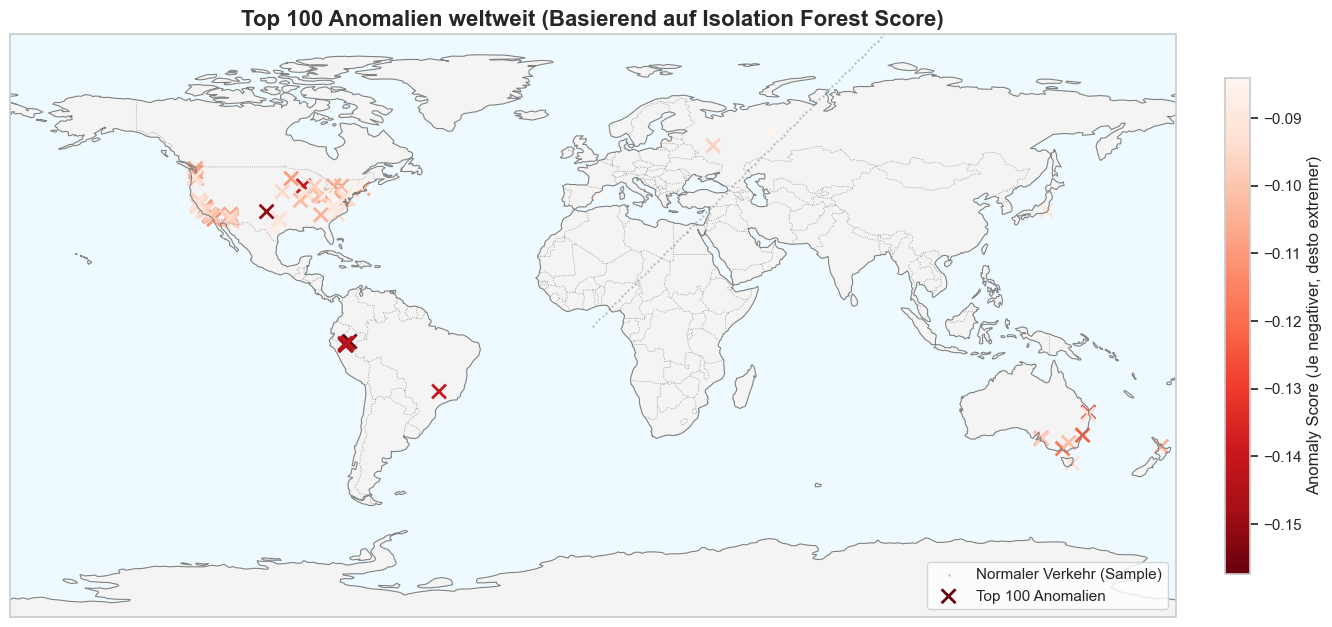

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from sklearn.ensemble import IsolationForest
import warnings

# SCHALLDÄMPFER
warnings.filterwarnings('ignore')

print("--- 2. ANOMALY DETECTION & GEOGRAFISCHE ANALYSE ---")

print("Trainiere Isolation Forest Modell...")

# 1. Features auswählen
features = ['velocity_kmh', 'baroaltitude']
X = df_clean[features].fillna(0)

# 2. Modell konfigurieren
model = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)

# 3. Trainieren & Vorhersagen
model.fit(X)

# 4. Ergebnisse speichern
df_clean['anomaly_label'] = model.predict(X) # -1 = Anomalie, 1 = Normal
df_clean['anomaly_score'] = model.decision_function(X) # Je kleiner (negativer), desto "schlimmer"

# Nur die Anomalien (-1) herausfiltern
anomalies = df_clean[df_clean['anomaly_label'] == -1].copy()

# Koordinaten sicherstellen
cols_geo = ['lat', 'lon']
for col in cols_geo:
    anomalies[col] = pd.to_numeric(anomalies[col], errors='coerce')

unique_anomalies = anomalies.sort_values('anomaly_score', ascending=True).drop_duplicates(subset=['icao24'])

top_100_anomalies = unique_anomalies.head(100)

print(f"Gefundene Anomalien (Gesamt): {len(anomalies):,}")
print(f"Top 100 extremste Fälle (nach Score dedupliziert) werden geplottet.")

plt.figure(figsize=(16, 10))

# Geo-Projektion
ax = plt.axes(projection=ccrs.PlateCarree())

# Grundkarte
ax.add_feature(cfeature.LAND, facecolor='#f4f4f4') 
ax.add_feature(cfeature.OCEAN, facecolor='#eefaff')     
ax.add_feature(cfeature.COASTLINE, linewidth=0.8, color='gray')       
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5, color='gray') 

# 1. Normaler Verkehr
df_normal = df_clean[df_clean['anomaly_label'] == 1].sample(frac=0.01, random_state=42)
ax.scatter(df_normal['lon'], df_normal['lat'],
           c='gray', s=1, alpha=0.3, transform=ccrs.PlateCarree(), label='Normaler Verkehr (Sample)')

# 2. Die Top 100 Anomalien
scatter = ax.scatter(top_100_anomalies['lon'], top_100_anomalies['lat'],
           c=top_100_anomalies['anomaly_score'], # Farbe nach Schweregrad
           cmap='Reds_r', # Dunkelrot = Extrem, Hellrot = Weniger extrem
           s=100, marker='x', linewidth=2, 
           transform=ccrs.PlateCarree(), label='Top 100 Anomalien')

# Design
ax.set_global()
plt.colorbar(scatter, label='Anomaly Score (Je negativer, desto extremer)', fraction=0.02, pad=0.04)
plt.title("Top 100 Anomalien weltweit (Basierend auf Isolation Forest Score)", fontsize=16, fontweight='bold')
plt.legend(loc='lower right')

plt.show()

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings('ignore')

sns.set_theme(style="whitegrid")

print("--- DATA QUALITY CHECK: DEEP DIVE ---")

# 1. SETUP
unique_flights_ids = df_clean['icao24'].unique()
total_flights = len(unique_flights_ids)

# Filterung der DB
df_quality = df_aircraft[df_aircraft['icao24'].isin(unique_flights_ids)].copy()

matches_count = len(df_quality)
match_rate = (matches_count / total_flights) * 100

print(f"Total Unique Aircraft im Feed: {total_flights:,}")
print(f"Davon in DB gefunden (Match):  {matches_count:,} ({match_rate:.1f}%)")

# 2. QUALITÄTS-ANALYSE
attributes = {
    'manufacturerName': 'Hersteller',
    'model': 'Modell',
    'typecode': 'Typ-Code',
    'categoryDescription': 'Kategorie',
    'operator': 'Airline/Betreiber'
}

quality_stats = []

for col, label in attributes.items():
    if col in df_quality.columns:
        valid_count = df_quality[col].replace(r'^\s*$', np.nan, regex=True).notna().sum()
        pct = (valid_count / total_flights) * 100 
        quality_stats.append({'Attribute': label, 'Valid_Count': valid_count, 'Percentage': pct})

df_stats = pd.DataFrame(quality_stats).sort_values('Percentage', ascending=False)

# 3. VISUALISIERUNG
plt.figure(figsize=(10, 6))

colors = ['#2ecc71' if x > 90 else '#f1c40f' if x > 70 else '#e74c3c' for x in df_stats['Percentage']]

ax = sns.barplot(
    data=df_stats, 
    x='Percentage', 
    y='Attribute', 
    hue='Attribute',
    palette=colors,
    legend=False     
)

for i, v in enumerate(df_stats['Percentage']):
    ax.text(v + 1, i, f"{v:.1f}%", color='black', va='center', fontweight='bold')

plt.title(f"Datenqualität: Metadaten-Vollständigkeit \n(Basis: {total_flights:,} Flugzeuge)", fontsize=15)
plt.xlabel("Abdeckung in %")
plt.ylabel("")
plt.xlim(0, 115) 
plt.axvline(x=100, color='grey', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# 4. TEXT-FAZIT
print("\n--- FAZIT ZUR DATENQUALITÄT ---")
for index, row in df_stats.iterrows():
    missing_pct = 100 - row['Percentage']
    print(f"• {row['Attribute']}: {row['Percentage']:.1f}% vorhanden (Fehlt bei {missing_pct:.1f}%)")

--- DATA QUALITY CHECK: DEEP DIVE ---


NameError: name 'df_aircraft' is not defined

### Zelle 4: Detail-Analyse: Top 50 identifizierte Anomalien

Um die abstrakten Statistik-Werte interpretierbar zu machen, verknüpfen wir sie mit physikalischem Kontext:

1.  **Daten-Fusion:** Wir joinen die Bewegungsdaten (Anomalien) mit der **Aircraft Database**, um Hersteller und Modell zu identifizieren.
2.  **Qualitäts-Filter:** Um Rauschen zu vermeiden, betrachten wir nur **eindeutig identifizierte Flugzeuge**.
3.  **Ranking:** Die Tabelle zeigt die **Top 50** der physikalisch auffälligsten Fälle, sortiert nach ihrem **Risk Score**.

In [ ]:
import pandas as pd
import os

print("--- 3. KONTEXT-ANREICHERUNG (Nur identifizierte Flugzeuge) ---")

# Sicherheits-Check
if 'unique_anomalies' not in locals():
    raise ValueError("Bitte führe Zelle 2 aus! Wir brauchen 'unique_anomalies'.")

# 1. STAMMDATEN LADEN
db_path = "../data/external/aircraft_database.parquet"
if not os.path.exists(db_path): db_path = "../../data/external/aircraft_database.parquet"
df_aircraft = pd.read_parquet(db_path)

print(f"Stammdaten geladen. Verknüpfe mit Anomalien...")

# 2. JOIN & FILTER
df_context = pd.merge(unique_anomalies, df_aircraft, on='icao24', how='left')
df_identified = df_context.dropna(subset=['manufacturerName', 'model']).copy()

# 3. SORTIEREN
column_mapping = {
    'anomaly_score': 'Risk Score',
    'icao24': 'ICAO ID',
    'manufacturerName': 'Hersteller',
    'model': 'Modell',
    'typecode': 'Typ',
    'velocity_kmh': 'Speed (km/h)',
    'baroaltitude': 'Höhe (m)'
}

# Spalten auswählen & umbenennen
final_table = df_identified[list(column_mapping.keys())].rename(columns=column_mapping)

# Runden
final_table['Speed (km/h)'] = final_table['Speed (km/h)'].round(1)
final_table['Höhe (m)'] = final_table['Höhe (m)'].round(0)
final_table['Risk Score'] = final_table['Risk Score'].round(4)

# Sortieren: Die schlimmsten Scores nach oben
final_table = final_table.sort_values('Risk Score', ascending=True)

# Top 50 auswählen
top_50 = final_table.head(50)

print(f"✅ Gefiltert: {len(df_identified)} Anomalien mit bekannten Metadaten.")
print("Hier sind die Top 50 identifizierten Fälle:")

display(top_50.set_index('ICAO ID'))